# Home Credit Default Risk
## Can you predict how capable each applicant is of repaying a loan?
Kaggle page: https://www.kaggle.com/c/home-credit-default-risk#description

**Description**

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

**Evaluation**

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.
For each SK_ID_CURR in the test set, you must predict a probability for the TARGET variable. The file should contain a header and have the following format:

    SK_ID_CURR,TARGET
    100001,0.1
    100005,0.9
    100013,0.2
    etc.

- **application_{train|test}.csv**
 - This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
 - Static data for all applications. One row represents one loan in our data sample.

- **bureau.csv**
 - All client\u0027s previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
 - For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

- **bureau_balance.csv**
 - Monthly balances of previous credits in Credit Bureau.
 - This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

- **POS_CASH_balance.csv**
 - Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
 - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

- **credit_card_balance.csv**
 - Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
 - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

- **previous_application.csv**
 - All previous applications for Home Credit loans of clients who have loans in our sample.
 - There is one row for each previous application related to loans in our data sample.

- **installments_payments.csv**
 - Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
 - There is a) one row for every payment that was made plus b) one row each for missed payment.
 - One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

- **HomeCredit_columns_description.csv**
 - This file contains descriptions for the columns in the various data files.

![Logical Schema](home_credit.png)

In [1]:
import os
import re
import datetime as dt
from time import time
import math
import random

# data science
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import randint as sp_randint

# data visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# machine learning
from sklearn.preprocessing import StandardScaler, Imputer, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [2]:
# configurations

# style for data visualizations
plt.style.use('fivethirtyeight')
%matplotlib inline
sns.set()

# Allow multiple outputs for each cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# display all columns
pd.set_option('display.max_columns', None)

# suppress auto-conversion to scientific notation
pd.set_option('display.precision', 6)

# Checkpoint1

In [7]:
# test = pd.read_csv('input/application_test.csv')
# train = pd.read_csv('input/application_train.csv')
split = 307511
df = pd.read_feather('input/checkpoint1.feather')
description = pd.read_excel('HomeCredit_columns_description.xlsx')

In [4]:
# inst_pmts = pd.read_csv('input/installments_payments.csv')
# prev_app = pd.read_csv('input/previous_application.csv')
# poscash_balance= pd.read_csv('input/POS_CASH_balance.csv')
# ccard_balance = pd.read_csv('input/credit_card_balance.csv')
# bureau_balance = pd.read_csv('input/bureau_balance.csv')
# bureau = pd.read_csv('input/bureau.csv')

# XGBoost

In [9]:
df.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANI

In [10]:
X = df[:split]
y = X['TARGET']
X.drop(['SK_ID_CURR','TARGET'],1,inplace=True)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [12]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [13]:
num_boost_round = 999

params = {'eta': .4,
          'max_depth': 6,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'objective':'binary:logistic',
          'eval_metric':'auc'}

In [14]:
model = xgb.train(params=params, 
                  dtrain=dtrain, 
                  num_boost_round=num_boost_round, 
                  early_stopping_rounds=10, 
                  evals=[(dtest, "Test")])

print("Best score : {:.2f} with {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-auc:0.718767
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.726482
[2]	Test-auc:0.730498
[3]	Test-auc:0.732303
[4]	Test-auc:0.733785
[5]	Test-auc:0.735284
[6]	Test-auc:0.736519
[7]	Test-auc:0.737694
[8]	Test-auc:0.739193
[9]	Test-auc:0.740768
[10]	Test-auc:0.741939
[11]	Test-auc:0.743377
[12]	Test-auc:0.744987
[13]	Test-auc:0.745415
[14]	Test-auc:0.74665
[15]	Test-auc:0.747124
[16]	Test-auc:0.747457
[17]	Test-auc:0.74792
[18]	Test-auc:0.748128
[19]	Test-auc:0.747891
[20]	Test-auc:0.747823
[21]	Test-auc:0.748234
[22]	Test-auc:0.748165
[23]	Test-auc:0.748376
[24]	Test-auc:0.748606
[25]	Test-auc:0.748484
[26]	Test-auc:0.749165
[27]	Test-auc:0.749454
[28]	Test-auc:0.749613
[29]	Test-auc:0.749582
[30]	Test-auc:0.749353
[31]	Test-auc:0.749448
[32]	Test-auc:0.749749
[33]	Test-auc:0.749447
[34]	Test-auc:0.74927
[35]	Test-auc:0.749594
[36]	Test-auc:0.749495
[37]	Test-auc:0.749307
[38]	Test-auc:0.749807
[39]	Test-auc:0.749841
[40]	Test-auc:0.750062
[41]	Test-auc:

# XGBClassifier

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [16]:
xgb1 = XGBClassifier(learning_rate =0.2,
                     n_estimators=100,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=1,
                     colsample_bytree=1,
                     objective= 'binary:logistic',
                     nthread=-1,
                     scale_pos_weight=1)

In [17]:
xgb1.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', verbose=True, early_stopping_rounds=5)

[0]	validation_0-auc:0.704251
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.710949
[2]	validation_0-auc:0.714649
[3]	validation_0-auc:0.71629
[4]	validation_0-auc:0.71884
[5]	validation_0-auc:0.72029
[6]	validation_0-auc:0.722169
[7]	validation_0-auc:0.723427
[8]	validation_0-auc:0.724223
[9]	validation_0-auc:0.725344
[10]	validation_0-auc:0.726938
[11]	validation_0-auc:0.72813
[12]	validation_0-auc:0.729452
[13]	validation_0-auc:0.730804
[14]	validation_0-auc:0.73258
[15]	validation_0-auc:0.733519
[16]	validation_0-auc:0.734886
[17]	validation_0-auc:0.735652
[18]	validation_0-auc:0.736312
[19]	validation_0-auc:0.737367
[20]	validation_0-auc:0.738024
[21]	validation_0-auc:0.738991
[22]	validation_0-auc:0.740075
[23]	validation_0-auc:0.741007
[24]	validation_0-auc:0.741275
[25]	validation_0-auc:0.741574
[26]	validation_0-auc:0.742064
[27]	validation_0-auc:0.742792
[28]	validation_0-auc:0.743274
[29]	validation_0-auc:0.743388
[30]	validation_0-auc:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [18]:
xgb1.evals_result()

{'validation_0': {'auc': [0.704251,
   0.710949,
   0.714649,
   0.71629,
   0.71884,
   0.72029,
   0.722169,
   0.723427,
   0.724223,
   0.725344,
   0.726938,
   0.72813,
   0.729452,
   0.730804,
   0.73258,
   0.733519,
   0.734886,
   0.735652,
   0.736312,
   0.737367,
   0.738024,
   0.738991,
   0.740075,
   0.741007,
   0.741275,
   0.741574,
   0.742064,
   0.742792,
   0.743274,
   0.743388,
   0.743639,
   0.743735,
   0.743798,
   0.744247,
   0.744515,
   0.74464,
   0.744873,
   0.744956,
   0.745168,
   0.745322,
   0.745516,
   0.745778,
   0.746014,
   0.746222,
   0.746258,
   0.7463,
   0.746158,
   0.7465,
   0.746468,
   0.746707,
   0.746759,
   0.746747,
   0.746981,
   0.747165,
   0.747208,
   0.747238,
   0.747213,
   0.747168,
   0.747119,
   0.747318,
   0.747199,
   0.74718,
   0.747066,
   0.747012]}}

In [19]:
y_pred = xgb1.predict_proba(X_train)
print(roc_auc_score(y_train, y_pred[:,1]))

0.779351751804309


In [20]:
y_pred = xgb1.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred[:,1]))

0.7468999105837343


Text(0.5,0,'False Positive Rate')

Text(0,0.5,'True Positive Rate')

Text(0.5,1,'ROC curve')

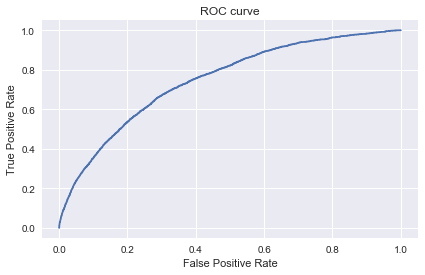

In [21]:
fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# Run with all data

In [22]:
y = df[:split]['TARGET']
X = df[:split].drop(['SK_ID_CURR','TARGET'],1)
test = df[split:].drop(['SK_ID_CURR','TARGET'],1)

xgb1 = XGBClassifier(learning_rate =0.1,
                     n_estimators=100,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic')

In [23]:
xgb1.fit(X, y, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='auc', verbose=True, early_stopping_rounds=5)

[0]	validation_0-auc:0.692282	validation_1-auc:0.685953
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.7221	validation_1-auc:0.717692
[2]	validation_0-auc:0.725895	validation_1-auc:0.720593
[3]	validation_0-auc:0.726944	validation_1-auc:0.72243
[4]	validation_0-auc:0.727708	validation_1-auc:0.723859
[5]	validation_0-auc:0.728365	validation_1-auc:0.724879
[6]	validation_0-auc:0.729065	validation_1-auc:0.726599
[7]	validation_0-auc:0.72965	validation_1-auc:0.727193
[8]	validation_0-auc:0.730537	validation_1-auc:0.728146
[9]	validation_0-auc:0.732977	validation_1-auc:0.73038
[10]	validation_0-auc:0.733406	validation_1-auc:0.730955
[11]	validation_0-auc:0.734132	validation_1-auc:0.73146
[12]	validation_0-auc:0.734502	validation_1-auc:0.731616
[13]	validation_0-auc:0.734645	validation_1-auc:0.731925
[14]	validation_0-auc:0.73476	validation_1-auc:0.732333
[15]	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [24]:
xgb1.evals_result()

{'validation_0': {'auc': [0.692282,
   0.7221,
   0.725895,
   0.726944,
   0.727708,
   0.728365,
   0.729065,
   0.72965,
   0.730537,
   0.732977,
   0.733406,
   0.734132,
   0.734502,
   0.734645,
   0.73476,
   0.736205,
   0.737189,
   0.737774,
   0.738712,
   0.739401,
   0.739938,
   0.740553,
   0.741012,
   0.741827,
   0.742205,
   0.742478,
   0.743514,
   0.744146,
   0.744618,
   0.744899,
   0.745382,
   0.746117,
   0.74668,
   0.747314,
   0.747785,
   0.748385,
   0.749166,
   0.750132,
   0.750784,
   0.751295,
   0.751456,
   0.751919,
   0.752336,
   0.753254,
   0.753869,
   0.754552,
   0.755123,
   0.75558,
   0.756063,
   0.756499,
   0.756927,
   0.757332,
   0.757916,
   0.758442,
   0.758783,
   0.759417,
   0.759826,
   0.76019,
   0.760654,
   0.760974,
   0.761384,
   0.761842,
   0.762136,
   0.762529,
   0.762875,
   0.763205,
   0.763583,
   0.763929,
   0.76437,
   0.764691,
   0.765073,
   0.765346,
   0.765512,
   0.765685,
   0.765869,
   0.76612

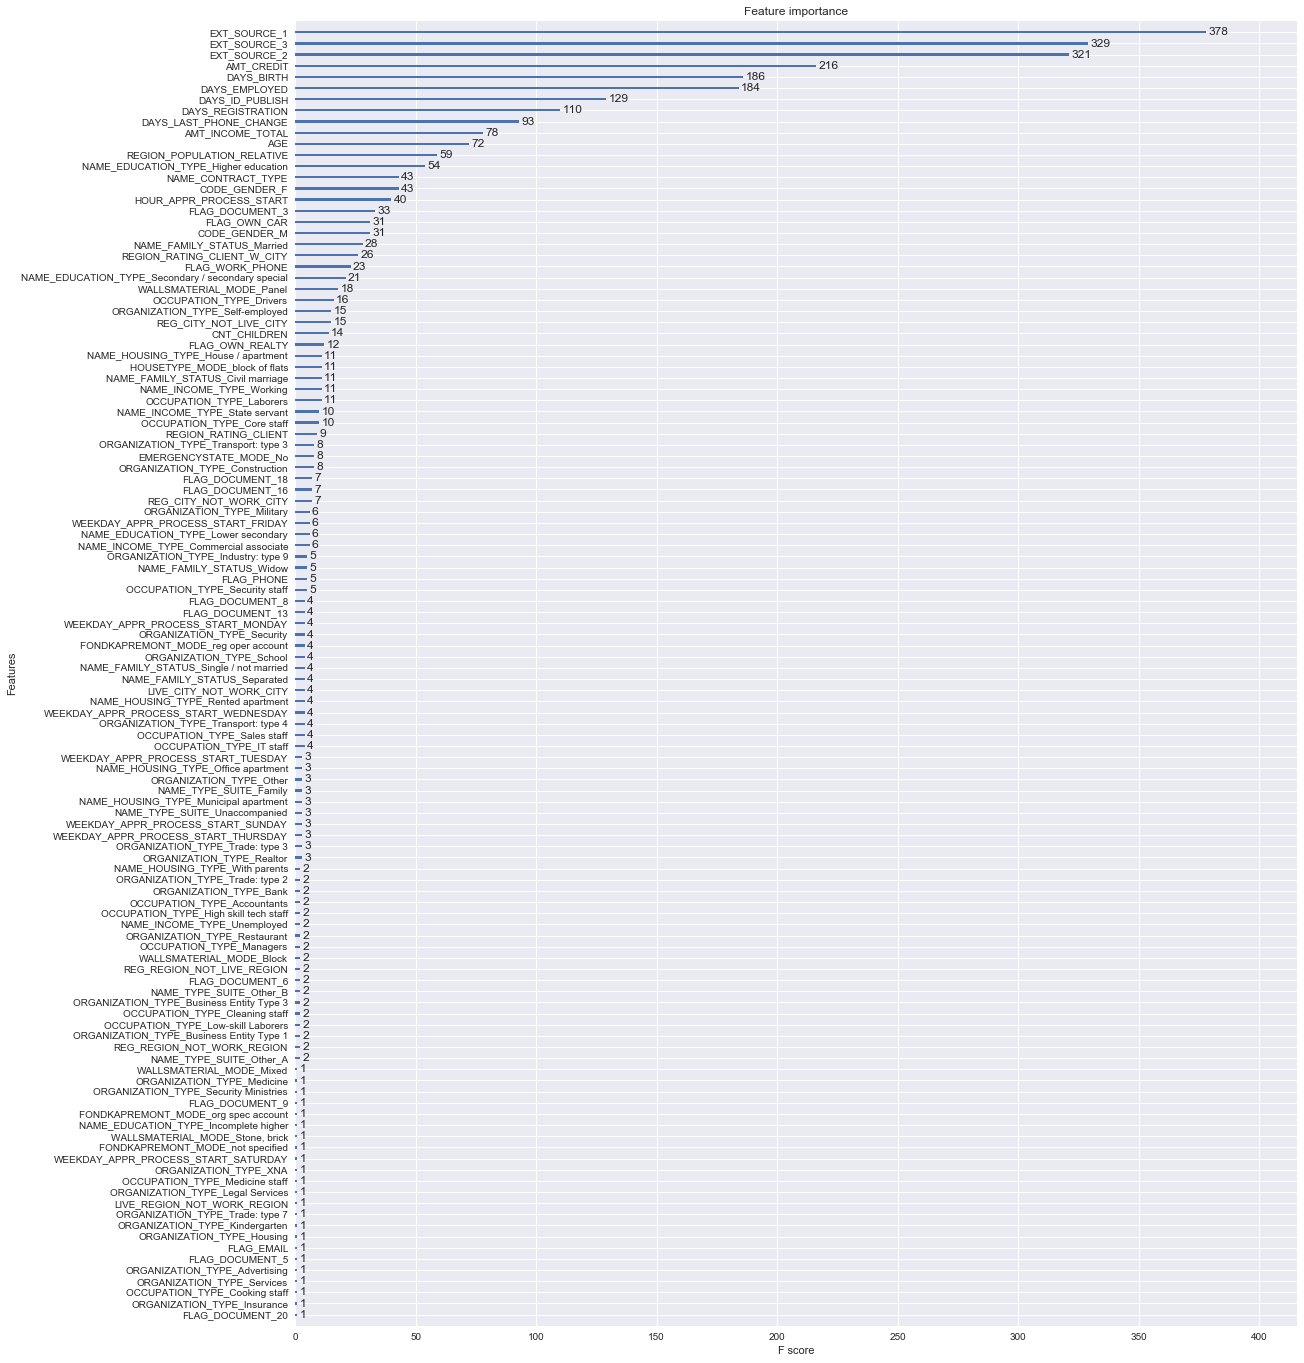

In [33]:
fig, ax = plt.subplots(1,1,figsize=(16,24))
xgb.plot_importance(xgb1, ax=ax)

## Submission

In [25]:
y_pred = xgb1.predict_proba(test)
y_pred

array([[0.95569754, 0.04430244],
       [0.903708  , 0.09629203],
       [0.9720727 , 0.0279273 ],
       ...,
       [0.94397193, 0.05602806],
       [0.9412859 , 0.05871407],
       [0.8333113 , 0.16668867]], dtype=float32)

In [26]:
submit = df[split:][['SK_ID_CURR']]
submit['TARGET'] = y_pred[:, 1]
submit

,SK_ID_CURR,TARGET
307511,100001,0.044302
307512,100005,0.096292
307513,100013,0.027927
307514,100028,0.043070
307515,100038,0.143841
307516,100042,0.041629
307517,100057,0.020228
307518,100065,0.041517
307519,100066,0.015764
307520,100067,0.064589


In [27]:
submit.to_csv('submission/submission2.csv', index = False)

<hr><br>

<h2>Result</h2>
<img src="submission/screenshot1.png" alt="screenshot1" style="width:800px;"/>
<br><hr><br>
<img src="submission/screenshot2.png" alt="screenshot2" style="width:800px;"/>
<br><hr><br>
<img src="submission/screenshot3.png" alt="screenshot3" style="width:800px;"/>

## Randomized Search

In [ ]:
from sklearn.grid_search import GridSearchCV

In [59]:
y = df[:split]['TARGET']
X = df[:split].drop(['SK_ID_CURR','TARGET'],1)
test = df[split:].drop(['SK_ID_CURR','TARGET'],1)

xgb1 = XGBClassifier(learning_rate =0.1,
                     n_estimators=100,
                     objective='binary:logistic')

params = {'max_depth': [3, 4, 5, 6],
          'min_child_weight': [1.0, 5.0, 10.0]}

# 'subsample': [0.6, 0.8, 1.0],
# 'colsample_bytree': [0.6, 0.8, 1.0]
# 'gamma': [0.5, 1, 1.5, 2, 5]

In [ ]:
gsearch1 = GridSearchCV(xgb1, param_grid=params, scoring='roc_auc', iid=False, cv=3)
gsearch1.fit(X, y)

In [ ]:
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_